# Transformers - Parte 1 (Encoder + Scaled Dot-Product Attention)

## 1. Intuição rápida: a grande troca

**Transformers** fazem uma troca fundamental: substituem *recorrência* e *convolução* por **atenção**.  
Em vez de processar palavras em sequência (como RNNs) ou com janelas locais (como CNNs), o Transformer permite que cada posição **"olhe" diretamente** para **qualquer outra posição** da sequência — e **em paralelo**.

**Vantagens práticas:**
- **Paralelização** massiva no treino (processa toda a sequência de uma vez)
- **Dependências longas** mais fáceis (um token pode "puxar" informação distante sem atravessar vários passos)
- **Capacidade de compor relações** variadas quando usamos **múltiplas cabeças** (cada cabeça aprende um "padrão" diferente)

---

### Motivação e Gap (do artigo *Attention Is All You Need*)

Antes dos Transformers, os modelos de transdução de sequência (como tradução automática, modelagem de linguagem etc.) eram dominados por **redes recorrentes** (RNNs, LSTMs, GRUs) ou **redes convolucionais** (CNNs). Embora eficazes, esses modelos apresentavam **limitações importantes**:

- **Natureza sequencial do processamento**:  
  Nas RNNs, cada passo depende do anterior. Isso impede a paralelização durante o treinamento dentro de uma mesma sequência, tornando o processo lento e custoso. Quanto mais longa a sequência, maior o problema de memória e tempo de treinamento.

- **Dificuldade em capturar dependências longas**:  
  CNNs e variantes como ConvS2S e ByteNet permitiram maior paralelização, mas a complexidade para relacionar dois tokens cresce com a distância entre eles (linear ou logarítmica). Isso torna mais difícil aprender dependências de longo alcance.

- **Uso limitado de atenção**:  
  Até então, mecanismos de atenção já eram usados em conjunto com RNNs, ajudando a modelar dependências distantes. Mas quase nunca eram aplicados de forma **independente** — ou seja, sem recorrer a camadas recorrentes ou convolucionais.

**O gap identificado:**  
Faltava uma arquitetura que conseguisse:  
1. **Dispensar completamente a recorrência e a convolução**, mantendo (ou melhorando) a qualidade dos resultados.  
2. **Aproveitar atenção de forma plena**, capturando dependências globais de forma direta e com custo constante (independente da distância entre tokens).  
3. **Permitir paralelização massiva**, reduzindo drasticamente o tempo de treinamento.

**A proposta do paper:**  
O **Transformer**, baseado *apenas* em mecanismos de atenção (self-attention), que elimina recorrência e convolução, atinge **maior qualidade em tradução automática**, com muito mais paralelização e menor tempo de treinamento.

## 2. Figura clássica do Transformer — explicação passo a passo (o que sai de cada pedaço)

<br/>
<img src="https://raw.githubusercontent.com/bmnogueira-ufms/TopicosIA-2025-02/main/images/transformers_architecture.png" width="60%%">

Fonte: Paper Attention is all you need (Wasani et al., 2017)

> **Mapa mental rápido (valores típicos do paper):**  
> - Camadas: **N = 6** no encoder e **N = 6** no decoder  
> - Dimensão do modelo: **d_model = 512**  
> - Cabeças de atenção: **h = 8**, com **d_k = d_v = d_model / h = 64**  
> - Feed-Forward interno: **d_ff = 2048**  
> Essas escolhas aparecem na descrição oficial do modelo e na Seção 3 do artigo.

**Convenções de forma (shapes):**  
- **B** = batch size  
- **n** = comprimento da sequência de entrada (source)  
- **m** = comprimento da sequência de saída (target)  
- **|V|** = tamanho do vocabulário  
- Tensores são do tipo `(B, seq_len, dimensão)`, salvo indicação contrária.

---

### 2.1) Inputs → *Tokenização*
**Entrada:** texto bruto (frases em linguagem natural).  
**Saída:** tensores de *ids* inteiros `(B, n)` para o **source** e `(B, m)` para o **target** (no treino, o target é deslocado para a direita — *shifted right*).  
**Intuição:** transformar palavras/subpalavras em índices para que possamos buscar vetores na tabela de embeddings.

---

### 2.2) *Input/Output Embedding*
**Entrada:** ids `(B, n)` (source) e `(B, m)` (target).  
**Operação:** tabelas de embeddings aprendidas (uma para entrada e outra para saída; no paper há compartilhamento de pesos com a projeção de saída).  
**Saída:**  
- **Encoder:** `E_src ∈ ℝ^{B×n×d_model}`  
- **Decoder (pré-máscara):** `E_tgt ∈ ℝ^{B×m×d_model}`  
**Intuição:** cada token vira um vetor denso em `d_model`; é o “espaço onde o modelo pensa”. O paper comenta embeddings aprendidos e o uso do *linear + softmax* no topo para prever o próximo token.  
---

### 2.3) **Positional Encoding (PE)** + soma aos embeddings
**Entrada:** `E_src`, `E_tgt`.  
**Operação:** adicionar encodings de posição (senoidais no paper) **elemento a elemento** aos embeddings.  
**Saída:**  
- **Encoder:** `X_src = E_src + PE_src  ∈ ℝ^{B×n×d_model}`  
- **Decoder:** `X_tgt = E_tgt + PE_tgt  ∈ ℝ^{B×m×d_model}`  
**Intuição:** como não há recorrência nem convolução, o modelo precisa “saber” a **ordem** dos tokens; PE injeta essa informação desde o início.  
---

### 2.4) **Encoder** (lado esquerdo da figura) — repetir **N** vezes
Cada **bloco de encoder** tem **duas** subcamadas, com **residual + LayerNorm** após cada uma:

#### 2.4.1) **Multi-Head Self-Attention** (MHA)
**Entrada:** `X_src (ou a saída normalizada da subcamada anterior) ∈ ℝ^{B×n×d_model}`  
**Operação:** projetar `Q, K, V` para cada cabeça (h no total), fazer atenção **self** (cada posição pode olhar **todas** as posições do source), concatenar cabeças e projetar de volta para `d_model`.  
**Saída:** `H_attn ∈ ℝ^{B×n×d_model}` + (opcional) pesos de atenção por cabeça `α ∈ ℝ^{B×h×n×n}`  
**Intuição:** cada posição mistura informação **global** do input; diferentes cabeças capturam **padrões complementares** (ex.: dependências de longo alcance, acordos gramaticais, etc.).  

#### 2.4.2) **Add & Norm** (após a atenção)
**Entrada:** *skip connection* `X_src` e `H_attn`.  
**Saída:** `Y₁ = LayerNorm(X_src + Dropout(H_attn)) ∈ ℝ^{B×n×d_model}`  
**Intuição:** preserva a informação original e estabiliza o treino (normalização no pós-soma). O paper especifica residual + LayerNorm após cada subcamada.  

#### 2.4.3) **Feed-Forward position-wise (FFN)**
**Entrada:** `Y₁`.  
**Operação:** **duas** projeções lineares com não linearidade no meio, aplicadas **independentemente por posição**:  
`FFN(x) = max(0, x W₁ + b₁) W₂ + b₂`  
**Saída:** `H_ffn ∈ ℝ^{B×n×d_model}`  
**Intuição:** após “misturar” contexto via atenção, o FFN transforma **cada vetor posição** para extrair/combinar características; pensa nisso como “MLP 1×1” por token.  

#### 2.4.4) **Add & Norm** (após o FFN)
**Entrada:** `Y₁` e `H_ffn`.  
**Saída:** `Z = LayerNorm(Y₁ + Dropout(H_ffn)) ∈ ℝ^{B×n×d_model}`  
**Intuição:** mantém o gradiente fluindo (residual) e padroniza estatísticas (LayerNorm). Esse `Z` vira a entrada da **próxima camada de encoder**; ao final da pilha (N×), obtemos a **memória do encoder**.

> **Saída final do Encoder (memória):** `M_enc = Z ∈ ℝ^{B×n×d_model}`  
> **Intuição:** uma representação rica do input, já contextualizada globalmente.

---

### 2.5) **Decoder** (lado direito) — repetir **N** vezes
Cada **bloco de decoder** tem **três** subcamadas (com residual + LayerNorm após cada uma):

#### 2.5.1) **Masked Multi-Head Self-Attention** (MHA com máscara causal)
**Entrada:** `X_tgt (ou a saída normalizada anterior) ∈ ℝ^{B×m×d_model}`  
**Operação:** atenção **self** no target, **com máscara causal** que zera conexões para posições **futuras** (garante propriedade auto-regressiva).  
**Saída:** `H_self ∈ ℝ^{B×m×d_model}`  
**Intuição:** cada posição do target só pode olhar **até si mesma** (e anteriores); durante inferência, isso impede olhar o “próximo token” antes de gerá-lo.  

#### 2.5.2) **Add & Norm** (após a self-attention do decoder)
**Entrada:** `X_tgt` e `H_self`.  
**Saída:** `Y₂ = LayerNorm(X_tgt + Dropout(H_self)) ∈ ℝ^{B×m×d_model}`  
**Intuição:** preserva representações originais do target e estabiliza o treino (mesma lógica do encoder).

#### 2.5.3) **Encoder–Decoder Attention (Cross-Attention)**
**Entrada:** `Y₂` (fornece **queries**) e `M_enc` (fornece **keys/values** do encoder).  
**Operação:** o decoder “pergunta” à memória do encoder **quais partes do source** são mais relevantes para **cada posição do target**; é MHA normal, mas agora **Q vem do decoder** e **K,V vêm do encoder**.  
**Saída:** `H_cross ∈ ℝ^{B×m×d_model}`  
**Intuição:** o decoder alinha/consulta o input inteiro para decidir **o que emitir** em cada passo do target.

#### 2.5.4) **Add & Norm** (após a cross-attention)
**Entrada:** `Y₂` e `H_cross`.  
**Saída:** `Y₃ = LayerNorm(Y₂ + Dropout(H_cross)) ∈ ℝ^{B×m×d_model}`  
**Intuição:** mistura informação do target com a **memória do encoder** de forma estável.

#### 2.5.5) **Feed-Forward position-wise (FFN)**
**Entrada:** `Y₃`.  
**Operação:** mesmo MLP por posição do encoder (duas lineares + ReLU).  
**Saída:** `H_ffn_dec ∈ ℝ^{B×m×d_model}`  
**Intuição:** refina a representação por posição no target, após integrar contexto do input.

#### 2.5.6) **Add & Norm** (após o FFN)
**Entrada:** `Y₃` e `H_ffn_dec`.  
**Saída:** `Z_dec = LayerNorm(Y₃ + Dropout(H_ffn_dec)) ∈ ℝ^{B×m×d_model}`  
**Intuição:** esta é a **saída da camada do decoder**; após repetir **N** vezes, obtemos a **representação final do decoder** para cada posição do target.  

---

### 2.6) **Linear → Softmax** (cabeçalho de saída)
**Entrada:** `Z_dec ∈ ℝ^{B×m×d_model}`  
**Operação:** projeção linear para o tamanho do vocabulário + softmax por token.  
**Saída:** `logits ∈ ℝ^{B×m×|V|}` → `probs ∈ ℝ^{B×m×|V|}`  
**Intuição:** para cada posição do target, obtemos uma **distribuição de probabilidade** sobre o próximo token; no treino, com *teacher forcing*, comparamos com o token-verdadeiro; na geração, usamos a **última posição** e amostramos/pegamos o argmax para produzir o próximo símbolo.

---

### 2.7) Por que isso funciona bem
- **Paralelização:** o encoder e a parte “por bloco” do decoder operam **em paralelo** nas posições da sequência (exceto pela máscara causal no decoder), superando o gargalo **sequencial** das RNNs.   
- **Dependências longas:** a self-attention conecta qualquer par de posições com **custo constante em camadas**, em contraste com CNNs (custo cresce com a distância); as **múltiplas cabeças** ajudam a mitigar a perda de “resolução” média.

> **Resumo visual da figura:**  
> Esquerda = **Encoder (N×)** com: *[Input Embedding + PE]* → **MHA** → **Add&Norm** → **FFN** → **Add&Norm**.  
> Direita = **Decoder (N×)** com: *[Output Embedding + PE]* → **Masked MHA** → **Add&Norm** → **Cross MHA (com memória do encoder)** → **Add&Norm** → **FFN** → **Add&Norm** → **Linear + Softmax**.  

## 3. Relembrando a fórmula da atenção (Scaled Dot-Product)

Dado um conjunto de vetores:
- **Q** (*queries*), **K** (*keys*) e **V** (*values*),
- Calculamos **similaridades** com `Q Kᵀ`, **escalamos** por `√dₖ`,
- Aplicamos **softmax** para virar **pesos**, e
- Fazemos a **média ponderada** dos valores **V**:

$$
\text{Attention}(Q,K,V) = \text{softmax}\!\left(\frac{Q K^\top}{\sqrt{d_k}}\right) V
$$

**Por que dividir por $\sqrt{d_k}$?**  
Sem essa divisão, quando a dimensionalidade \(d_k\) cresce, os produtos internos podem ficar muito grandes, empurrando a distribuição do softmax para extremos. A escala \(\sqrt{d_k}\) ajuda a manter os logits em uma faixa mais estável, melhorando gradientes e treinamento.

## 4. Anatomia do encoder

**Uma camada de encoder** (a típica do Transformer) contém:
1) **Self-Attention** (aqui, sem máscara)  
2) **Residual + LayerNorm**  
3) **Feed-Forward** position-wise (duas lineares + não linearidade)  
4) **Residual + LayerNorm** novamente

**Importante:** Aqui implementaremos o "miolo" da etapa (1), com **uma cabeça** para enxergar as formas e pesos. Depois, generalizamos para **múltiplas cabeças** (multi-head) e integramos todo o bloco.

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random

def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)

set_seed(7)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def shape(x, name=None):
    """Imprime forma, dtype e device de um tensor para facilitar a didática."""
    tag = f"[{name}] " if name else ""
    print(f"{tag}shape={tuple(x.shape)}  dtype={x.dtype}  device={x.device}")

def peek(x, n=3):
    """Mostra os n primeiros elementos do tensor (no CPU) para inspeção."""
    print(x.detach().cpu().numpy()[:n])

## 5. Implementação simples da Scaled Dot-Product Attention (uma cabeça)

O plano:
1) Receber tensores **Q**, **K** e **V** com formas compatíveis  
2) Calcular os **logits** = $ QK^\top / \sqrt{d_k} $  
3) Aplicar **máscara** (se houver) para "zerar" posições proibidas  
4) Rodar **softmax** (ao longo do eixo das chaves) → **pesos**  
5) Multiplicar por **V** → **saída** da atenção  
6) Retornar também os **pesos** para podermos visualizá-los

In [2]:
# Scaled Dot-Product Attention (uma cabeça), com máscara opcional
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Parâmetros:
      Q: (batch, seq_q, d_k)
      K: (batch, seq_k, d_k)
      V: (batch, seq_k, d_v)
      mask: (batch, seq_q, seq_k) com 1 onde PODE atender e 0 onde NÃO pode

    Retorno:
      out: (batch, seq_q, d_v)
      attn_weights: (batch, seq_q, seq_k)
    """
    d_k = Q.size(-1)
    # 1) Logits de atenção (similaridade entre consultas e chaves), com escala
    logits = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(d_k)  # (B, seq_q, seq_k)

    # 2) Máscara opcional: posições proibidas recebem -inf → peso ~ 0 após softmax
    if mask is not None:
        logits = logits.masked_fill(mask == 0, float("-inf"))

    # 3) Softmax para virar distribuição de probabilidade (pesos por linha)
    attn_weights = F.softmax(logits, dim=-1)  # (B, seq_q, seq_k)

    # 4) Combina valores V segundo os pesos
    out = torch.matmul(attn_weights, V)       # (B, seq_q, d_v)
    return out, attn_weights

## 6. Exemplo de **pesos de atenção reais**

Vamos usar uma frase curtinha em português. Não vamos treinar nada; só faremos *forward* para **visualizar como cada token "olha" para os demais**.

- Tokenização simples por espaço (para fins didáticos)  
- Vocabulário pequeno, incluindo `<bos>` (início) e `<eos>` (fim)  
- **Embeddings aleatórios** apenas para visualizar formas e o fluxo

In [4]:
# Vocabulário mínimo e tokenização simples
vocab = {
    "<pad>": 0, "<bos>": 1, "<eos>": 2,
    "o": 3, "gato": 4, "preto": 5, "correu": 6, ".": 7
}
ivocab = {i: t for t, i in vocab.items()}

def tokenize(text):
    return text.lower().strip().split()

def encode(tokens, add_bos=True, add_eos=True):
    ids = []
    if add_bos: ids.append(vocab["<bos>"])
    for t in tokens:
        ids.append(vocab.get(t, vocab["<pad>"]))
    if add_eos: ids.append(vocab["<eos>"])
    return ids

sent_pt = "O gato preto correu ."
ids = encode(tokenize(sent_pt))
ids

[1, 3, 4, 5, 6, 7, 2]

In [14]:
# (cont.) — Embeddings aleatórios para visualizar formas
d_model = 16  # pequeno para facilitar impressão/entendimento
embedding = nn.Embedding(num_embeddings=len(vocab), embedding_dim=d_model)

x = torch.tensor(ids, dtype=torch.long).unsqueeze(0)  # (1, seq)
emb = embedding(x).to(device)                         # (1, seq, d_model)

shape(emb, "emb")
peek(emb[0], n=3)  # mostra só os 3 primeiros vetores da sequência

[emb] shape=(1, 7, 16)  dtype=torch.float32  device=cpu
[[ 0.92  -0.048  0.105  1.777  1.91  -1.284 -0.625 -1.382 -0.837  1.281
   0.74  -0.66   0.759  0.25   0.163  1.559]
 [ 0.165 -1.693 -0.611  0.896 -0.036 -0.566  0.395 -0.027 -0.272 -1.861
  -0.984  1.02  -0.967  0.733  0.451  1.157]
 [ 0.344  0.11   0.011  0.488 -0.893  1.733  0.217 -1.571 -0.387 -0.984
  -2.514 -0.628  0.055  1.139  0.863 -0.097]]


## 7. Projeções lineares: gerando Q, K, V (1 cabeça)

Atenção funciona com três conjuntos de vetores:
- **Queries (Q)**: "o que estou buscando?"
- **Keys (K)**: "que tipo de informação guardo?"
- **Values (V)**: "qual informação entrego quando sou relevante?"

Na prática, obtemos Q/K/V aplicando **projeções lineares** ao mesmo `emb` (ou seja, três `Linear` diferentes).  
Nesta sessão, faremos **apenas 1 cabeça**. Na próxima, veremos **multi-head**, onde particionamos o espaço em subespaços para aprender *padrões complementares*.

In [15]:
# 1.8 — Projeções lineares para Q/K/V (uma cabeça)
d_k = d_v = d_model  # para 1 cabeça didática, mantemos igual
W_Q = nn.Linear(d_model, d_k, bias=False).to(device)
W_K = nn.Linear(d_model, d_k, bias=False).to(device)
W_V = nn.Linear(d_model, d_v, bias=False).to(device)

Q = W_Q(emb)  # (1, seq, d_k)
K = W_K(emb)  # (1, seq, d_k)
V = W_V(emb)  # (1, seq, d_v)

shape(Q, "Q"); shape(K, "K"); shape(V, "V")

[Q] shape=(1, 7, 16)  dtype=torch.float32  device=cpu
[K] shape=(1, 7, 16)  dtype=torch.float32  device=cpu
[V] shape=(1, 7, 16)  dtype=torch.float32  device=cpu


## 8. Self-Attention no encoder (sem máscara)

No **encoder**, todas as posições **podem** se atender mutuamente (não há "futuro proibido").  
Vamos calcular a saída de atenção e inspecionar **as formas** e **os pesos**:

- `out` tem mesma quantidade de posições que a entrada, mas cada posição agora é uma **combinação ponderada** dos `V` de todas as posições (segundo os pesos aprendidos).
- `attn_weights[i, j]` indica **quanto** a posição *i* "olhou" para a posição *j*.

In [18]:
# 1.9 — Atenção do encoder (sem máscara)
out, attn = scaled_dot_product_attention(Q, K, V, mask=None)

shape(out,  "out")
shape(attn, "attn_weights")

# Tokens correspondentes às posições
tokens = [ivocab[i] for i in ids]
print("Tokens:", tokens)

# Pesos de atenção da primeira posição (índice 0)
np.set_printoptions(precision=3, suppress=True)
print("\nPesos de atenção para o token na posição 0:")
print(attn[0, 0].detach().cpu().numpy())

# "tabelinha amigável" (linhas=consultas, colunas=chaves)
print("\nMatriz de atenção (valores ~ somam 1 por linha):")
mat = attn[0].detach().cpu().numpy()
print(mat)

[out] shape=(1, 7, 16)  dtype=torch.float32  device=cpu
[attn_weights] shape=(1, 7, 7)  dtype=torch.float32  device=cpu
Tokens: ['<bos>', 'o', 'gato', 'preto', 'correu', '.', '<eos>']

Pesos de atenção para o token na posição 0:
[0.127 0.072 0.115 0.173 0.172 0.117 0.224]

Matriz de atenção (valores ~ somam 1 por linha):
[[0.127 0.072 0.115 0.173 0.172 0.117 0.224]
 [0.226 0.074 0.094 0.176 0.129 0.172 0.129]
 [0.153 0.094 0.136 0.146 0.132 0.164 0.177]
 [0.16  0.147 0.14  0.153 0.134 0.136 0.129]
 [0.142 0.151 0.169 0.111 0.118 0.123 0.185]
 [0.147 0.122 0.131 0.14  0.157 0.146 0.156]
 [0.153 0.163 0.138 0.168 0.085 0.156 0.137]]


## 9. Visualização: heatmap dos pesos de atenção

Para fins pedagógicos, um heatmap ajuda a **enxergar** rapidamente padrões (por exemplo, o token "preto" atendendo mais "gato").  
Se você estiver em um ambiente sem interface gráfica, pode pular esta etapa.

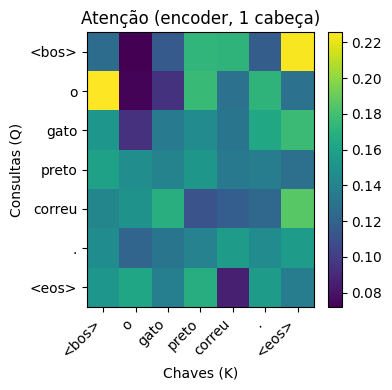

In [20]:
# 1.10 — Heatmap simples dos pesos de atenção
import matplotlib.pyplot as plt

def plot_attn(attn_matrix, tokens, title="Atenção (encoder, 1 cabeça)"):
    """
    attn_matrix: (seq, seq) — uma única matriz (por exemplo, attn[0])
    tokens: lista de strings com o rótulo de cada posição
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(attn_matrix, aspect="auto")
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha="right")
    ax.set_yticklabels(tokens)
    ax.set_xlabel("Chaves (K)")
    ax.set_ylabel("Consultas (Q)")
    ax.set_title(title)
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()

plot_attn(attn[0].detach().cpu().numpy(), tokens)

## 10. A Rede Feed-Forward Position-Wise (FFN)

Dentro de **cada camada** do encoder e do decoder, além da atenção, existe uma **rede feed-forward totalmente conectada**, aplicada **separadamente em cada posição** da sequência.  

No artigo *Attention Is All You Need*, ela é definida assim :

$$
\text{FFN}(x) = \max(0, \, xW_1 + b_1)\, W_2 + b_2
$$

### Estrutura
- **Entrada:** vetor de dimensão `d_model` (ex.: 512).  
- **Primeira transformação linear:** projeta para uma dimensão maior, chamada `d_ff` (no paper, 2048).  
- **ReLU:** ativações não lineares, dando capacidade de aprender transformações complexas.  
- **Segunda transformação linear:** projeta de volta para `d_model`.  
- **Saída:** vetor refinado, mesma dimensão da entrada (`d_model`).

### Formas (shapes)
Se a entrada da camada for `(B, seq_len, d_model)`:
1. Primeira linear → `(B, seq_len, d_ff)`  
2. ReLU → `(B, seq_len, d_ff)`  
3. Segunda linear → `(B, seq_len, d_model)`  
4. Resultado final → mesma forma da entrada, mas com **informação transformada**.

### Intuição
- A **atenção** mistura informações **entre diferentes posições** da sequência.  
- A **FFN** atua **dentro de cada posição individualmente**, como se fosse um pequeno MLP aplicado token a token.  
- É como se o modelo tivesse dois momentos complementares:  
  - **Atenção:** decide *“de onde puxar informação”*.  
  - **FFN:** decide *“como processar essa informação dentro do token”*.  

### Detalhes importantes
- Os **pesos** (`W1`, `W2`, `b1`, `b2`) são **iguais para todas as posições** da sequência (compartilhados), garantindo consistência.  
- Mas **cada camada** do encoder e do decoder tem **seu próprio conjunto de pesos** — ou seja, a camada 3 não compartilha parâmetros com a camada 4.  
- Outra forma de ver: o FFN é equivalente a **duas convoluções 1×1** (kernel size = 1), já que cada posição é processada de forma independente.  

Em resumo: a atenção conecta posições diferentes, e a FFN “refina” cada posição individualmente. Juntas, elas permitem que cada token seja informado pelo contexto global e, ao mesmo tempo, processado localmente para extrair representações mais expressivas.

## 10. Exercício

1) **Altere a frase** para “O gato correu .” (remova “preto”).  
2) **Reexecute** as células e observe como a **matriz de atenção** muda.  
3) Aumente `d_model` para `32` e veja o impacto nos valores.  
4) Explique: em que casos você **espera** que “gato” atenda mais a “preto”?  
   - Dica: pense na relação *substantivo ↔ adjetivo* e na **co-ocorrência** semântica.

## 11. Considerações Finais

Agora que você:
- Entendeu a **fórmula central** da atenção e viu pesos reais,
- Observou o **fluxo de tensores** (formas de Q, K, V, pesos e saída),

…vamos **generalizar**:

**Na próxima aula:**
- **Multi-Head Attention (MHA)**: dividir o espaço em `h` cabeças ($ d_k = d_v = d_{\text{model}} / h $), atender **em paralelo** e **concatenar**.  
- **Projeção de saída (Wᵒ)** após concatenar as cabeças.  
- **Máscara causal** no **decoder** (impedir “olhar o futuro”) e intuição do **modo auto-regressivo**.  
- **Positional Encoding** senoidal: por que resolve a “dor” da ordem, fórmula completa e interpretação geométrica.

## Referência

VASWANI, Ashish; SHAZEER, Noam; PARMAR, Niki; USZKOREIT, Jakob; JONES, Llion; GOMEZ, Aidan N.; KAISER, Łukasz; POLOSUKHIN, Illia. Attention is all you need. In: Advances in Neural Information Processing Systems (NeurIPS 2017). [S.l.: s.n.], 2017. p. 5998–6008.